<a href="https://colab.research.google.com/github/aglucky/Basic_Sim/blob/main/Basic_Sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random
import numpy as np
import uuid
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style='darkgrid')
%matplotlib inline

#Functions

In [ ]:
def dist(x1,y1,x2,y2):
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def limit(x,y,posLim):
  if x < posLim[0]: x = posLim[0]
  if y < posLim[0]: y = posLim[0]
  if y > posLim[1]: y = posLim[1]
  if x > posLim[1]: x = posLim[1]
  return x,y

#Food

In [ ]:
class food():
  def __init__(self,x,y):
    self.x = x
    self.y = y
    self.stamina = 5
    self.state = 1 #1 = present, 0 = eaten

def makeFood(foods,foodCount,posLim):
  cols = posLim[1]
  rows = posLim[3]
  foods.clear()
  for i in range(foodCount):
    x = random.randint(0,cols)
    y = random.randint(0,rows)
    foods.append(food(x,y))
  return foods
      

#Organism

In [ ]:
class organism():
  def __init__(self, x, y, size, speed, vision, id):
    self.x = x
    self.y = y
    self.size = size
    self.speed = speed
    self.vision = vision
    self.see = []
    self.id = id
    self.state = 1 #0 = dead, 1 = idle, 2 = hunt, 3 = flee, 4 = no energy
    self.fitness = 0
    self.energy = 150
    self.stamina = 5
    self.enCost = ((size**3)*(speed**2))+vision
    self.age = 0

  def canEat(self,org):
    if isinstance(org,food):
      return True
    elif self.size>org.size*1.2:
      return True
    else:
      return False

  def canSee(self,organisms,foods):
    self.see.clear()

    for fod in foods:
      if dist(self.x,self.y,fod.x,fod.y)<= self.vision:
        self.see.append(fod)
      for org in organisms:
        if dist(self.x,self.y,org.x,org.y)<= self.vision and self.id != org.id:
          self.see.append(org)

  def isNear(self):
    if len(self.see) == 0:
      return False
    else:
      return True

  def findNearestOrg(self):
      closeOrg = self.see[0]
      for org in self.see:
        if isinstance(org,food):
          if dist(closeOrg.x,closeOrg.y,self.x,self.y)>dist(org.x,org.y,self.x,self.y):
            closeOrg = org
        elif dist(closeOrg.x,closeOrg.y,self.x,self.y)>dist(org.x,org.y,self.x,self.y) and self.id != org.id:
          closeOrg = org

      return closeOrg

 
  def fleeOrFight(self,org):
    if self.size>org.size*1.2:
      self.state = 2

    elif self.size<org.size:
      self.state = 3
    
    else:
      self.state = 1

  def update_pos(self, dx, dy):
    self.x = round(self.x+dx)
    self.y = round(self.y+dy)

  def boundCheck(self,posLim):
    self.x,self.y = limit(self.x,self.y,posLim)

    
  def chase(self, org):
    ang = 0
    if org.x == self.x and org.y == self.y:
      dx=0
      dy=0

    elif org.x == self.x:
      if self.y < org.y:
        ang = np.pi/2
      else:
        ang = 3 * (np.pi/2)

    else:
      a = org.y-self.y
      b = org.x-self.x
      c = np.sqrt((a)**2+(b)**2)
      ang = np.arccos(a/c) 

    dx = self.speed*np.cos(ang)
    dy = self.speed*np.sin(ang)

    if abs(self.x-org.x)<self.speed:
      self.x = org.x
      dx = 0

    if abs(self.y-org.y)<self.speed:
      self.y = org.y
      dy = 0
    
    self.update_pos(dx, dy)

  def flee(self, org, posLim):
    xMin = posLim[0]
    xMax = posLim[1]
    yMin = posLim[2]
    yMax = posLim[3]

    if self.edgeAct(org,posLim):
      pass
      
    else:

      ang = 0
      if org.x == self.x:
        if self.y < org.y  :
          ang = 3 * (np.pi/2)
        else:
          ang = np.pi/2

      elif org.y == self.y:
        if self.x > org.x  :
          ang = 2 * np.pi
        else:
          ang = np.pi

      else:
        a = org.y-self.y
        b = org.x-self.x
        c = np.sqrt((a)**2+(b)**2)
        ang = (np.arccos(a/c)+np.pi)/(2*np.pi) 

      dx = self.speed*np.cos(ang)
      dy = self.speed*np.sin(ang)

      self.update_pos(dx, dy)
    

  def edgeAct(self,org,posLim):
    xMin = posLim[0]
    xMax = posLim[1]
    yMin = posLim[2]
    yMax = posLim[3]
    cornerCount = []

    #Corner Check
    if self.x<xMin:
      self.x = xMin
      cornerCount.append('down')

    if self.x>xMax:
      self.x = xMax
      cornerCount.append('up')
        

    if self.y<yMin:
      self.y = yMin
      cornerCount.append('left')


    if self.y>yMax:
      self.y = yMax
      cornerCount.append('right')

    if len(cornerCount)==2:

      #Top Right Corner
      if cornerCount[0] == 'up' and cornerCount[1] == 'right':
        choice = random.randint(-1,1)
        
        if choice == -1:
          self.update_pos(-1*self.speed,0)
        if choice == 1:
          self.update_pos(0,-1*self.speed)

      #Top Left Corner
      if cornerCount[0] == 'up' and cornerCount[1] == 'left':
        choice = random.randint(-1,1)
        
        if choice == -1:
          self.update_pos(self.speed,0)
        if choice == 1:
          self.update_pos(0,-1*self.speed)

      #Bottom Right Corner
      if cornerCount[0] == 'down' and cornerCount[1] == 'right':
        choice = random.randint(-1,1)
        
        if choice == -1:
          self.update_pos(-1*self.speed,0)
        if choice == 1:
          self.update_pos(0,self.speed)

      #Top Left Corner
      if cornerCount[0] == 'down' and cornerCount[1] == 'left':
        choice = random.randint(-1,1)
        
        if choice == -1:
          self.update_pos(self.speed,0)
        if choice == 1:
          self.update_pos(0,self.speed)

#Edge Check/Act
    else:
      if self.x<xMin:
        self.x = xMin
        if org.y<self.y:
          self.y+= self.speed
        elif org.y>self.y:
          self.y+=-1*self.speed
          

      if self.x>xMax:
        self.x = xMax
        if org.y<self.y:
          self.y+= self.speed
        elif org.y>self.y:
          self.y+=-1*self.speed
          

      if self.y<yMin:
        self.y = yMin
        if org.x<self.x:
          self.x+= self.speed
        elif org.x>self.x:
          self.x+=-1*self.speed
          

      if self.y>yMax:
        self.y = yMax
        if org.x<self.x:
          self.x+= self.speed
        elif org.x>self.x:
          self.x+=-1*self.speed
          
    if len(cornerCount)> 0:
      return True
    else:
      return False

  def idleMove(self):
    dx = random.randint(-1,1)*self.speed
    dy = random.randint(-1,1)*self.speed
    self.update_pos(dx,dy)


#Simulate

In [ ]:
 def simulate(time,organisms,foods,posLim,last):
    orgEatRate = 0
    org_x = []
    org_y = []
    org_size = []
    food_x = []
    food_y = []

    for t_step in range(0, time): 

      #Graph if last gen
      if last == True: 
        org_x.clear()
        org_y.clear()
        org_size.clear()
        food_x.clear()
        food_y.clear()

        for fod in foods:
          food_x.append(fod.x)
          food_y.append(fod.y)

        for org in organisms:
          org_x.append(org.x)
          org_y.append(org.y)
          org_size.append(org.size)
        
        plt.scatter(org_x, org_y, s=org_size, c='r')
        plt.scatter(food_x, food_y, s=1.5, c='b')

        plt.title('Simulation Enviorment')
        plt.xlabel('X Positions')
        plt.ylabel('Y Positions')
        plt.xlim(0,53)
        plt.ylim(0,53)
        fileName = 'frame:' + str(t_step+1)
        images_dir = '/content/drive/MyDrive/basicSimFrames'
        plt.savefig("{}/{}".format(images_dir,fileName))
        plt.clf()
     
      for org in organisms:
        if org.energy <org.enCost:
          org.state = 4
        else:
          org.canSee(organisms,foods)
          
          if org.isNear()==False:
            org.state = 1
          else:
            near = org.findNearestOrg()
            if isinstance(near,food):
              org.state =2
            else:
              if org.canEat(near):
                org.state = 2
              else:
                org.state = 3

        if org.state == 1:
          org.idleMove()
          org.x,org.y = limit(org.x,org.y,posLim)
        
        elif org.state == 2:
          org.chase(near)
          org.x,org.y = limit(org.x,org.y,posLim)
          if org.x == near.x and org.y==near.y and org.canEat(near):
            org.energy+=near.stamina
            near.state=0
            org.fitness+=1
        
        elif org.state == 3:
          org.flee(near,posLim)
          org.x,org.y = limit(org.x,org.y,posLim)

        org.stamina= org.stamina - org.enCost

        #Remove eaten objects
        for check in organisms:
          if check.state == 0:
            organisms.remove(check)
            orgEatRate +=1

        for check in foods:
          if check.state == 0:
            foods.remove(check)

    return organisms,orgEatRate



#Genetic Algorithim Methods


#Reproduce Method

In [ ]:
 def reproduce(org_1, org_2, mutation_prob=0.1):
    child = []
    parent_1 = [org_1.size,org_1.speed,org_1.vision]
    parent_2 = [org_2.size,org_2.speed,org_2.vision]

    crossover = random.randint(0,3)

    for i in range(3):
      if i<crossover:
        child.append(parent_1[i])
      else:
        child.append(parent_2[i])
    
    for i in range(3):
      if round(random.uniform(0.0,1.0),2)<=mutation_prob:
        child[i] = child[i] + (child[i]*random.uniform(-.5,.5))

    size = round(child[0],2)
    speed = round(child[1],2)
    vision = round(child[2],2)

    x = random.randint(0,50)
    y = random.randint(0,50)

    return organism(x,y,size,speed,vision,uuid.uuid4())

#Evolution Method

In [ ]:
def evolve(organisms):
  newGen = []
  children = []
  parents = []
  count = 0
  birthRate = 0
  deathAdd = len(organisms)

 #Wipe out weak organisms
  for org in organisms:
    if org.fitness > 0:
      count +=1

  if count == 0:
    for i in range(random.randint(1,len(organisms))):
      fit = organisms[0]
      for org in organisms:
        if org.fitness>fit.fitness:
          fit = org
      newGen.append(fit)

    for i in range(random.randint(1,len(newGen))):
      parent = newGen[0]
      for org in newGen:
        if org.fitness>fit.fitness:
          parent = org
      newGen.append(parent)

  else:

    for i in range(len(organisms)):
      if organisms[i].fitness==1:
        newGen.append(organisms[i])
        deathAdd-=1
      elif organisms[i].fitness>=2:
        parents.append(organisms[i])
        newGen.append(organisms[i])
        deathAdd-=1


  #Reproduce
  while len(parents) > 0:
    if len(parents) == 1:
      parent_1 = parents[0]
      parent_2 = parents[0]
      parents.clear()
    else:
      parent_1 = random.choice(parents)
      parents.remove(parent_1)

      parent_2 = random.choice(parents)
      parents.remove(parent_2)

      for i in range(5):
        chance = (parent_1.fitness+parent_2.fitness)/20

        if random.uniform(0,1)<chance:
          children.append(reproduce(parent_1,parent_2,mutation_prob=0.1))
          birthRate+=1

  while len(children)>0:
    if len(children) == 1:
      newGen.append(children[0])
      children.remove(children[0])
    else:
      kidAdd = children[random.randint(0,len(children)-1)]
      children.remove(kidAdd)
      newGen.append(kidAdd)

  for org in newGen:
    org.fitness = 0
    org.energy = 150

  return newGen,birthRate,deathAdd

#Run

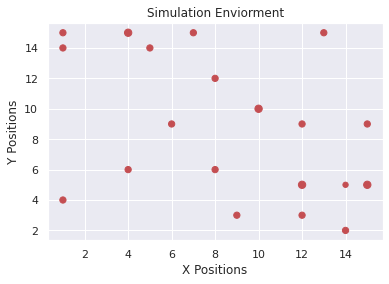

In [ ]:
#Setup
rows, cols = (15, 15) 
posLim = [0,cols,0,rows]
gen = 50
popCount = 15
foodCount = 30
organisms = []
foods = []
#Stats
totalSize = 0
totalSpeed = 0
totalVision = 0
sizeStat =[]
speedStat=[]
visionStat=[]
ageStat = []
numOrgs = []
foodEaten = []
birthStat = []
orgEatStat = []
selectKillStat = []
totalDeathStat = []
averageFitness = []
#Plotting enviorment
xOrg =[]
yOrg = []
area = []
xFood =[]
yFood =[]
#Return
bestOrgs = []

for i in range(popCount):
  x = random.randint(0,cols)
  y = random.randint(0,rows)
  size = random.uniform(0.00,2.00)
  speed = random.uniform(0.00,2.00)
  vision = random.uniform(0.00,4.00)
  organisms.append(organism(x,y,size,speed,vision, uuid.uuid4()))
  totalSize += size
  totalSpeed += speed
  totalVision += vision

for i in range(foodCount):
  x = random.randint(0,cols)
  y = random.randint(0,rows)
  foods.append(food(x,y))

#Initial stats
numOrgs.append(len(organisms))
foodEaten.append(len(foods))
sizeStat.append(totalSize/len(organisms))
speedStat.append(totalSpeed/len(organisms))
visionStat.append(totalVision/len(organisms))

#Run Simulaion
for i in range(gen):
  totalSize = 0
  totalSpeed = 0
  totalVision = 0
  totalAge = 0
  totalFitness = 0

  foods = makeFood(foods,foodCount,posLim)

  #Run 1 Round
  if i == gen-1:
    organisms,eat = simulate(100,organisms,foods,posLim,True)
  else:
    organisms,eat = simulate(100,organisms,foods,posLim,False)




  for org in organisms:
    org.age += 1
    totalSize += org.size
    totalSpeed += org.speed
    totalVision += org.vision
    totalAge+=org.age
    totalFitness += org.fitness
  sizeStat.append(totalSize/len(organisms))
  speedStat.append(totalSpeed/len(organisms))
  visionStat.append(totalVision/len(organisms))
  ageStat.append(totalAge/len(organisms))
  numOrgs.append(len(organisms))
  foodEaten.append(foodCount - len(foods))
  averageFitness.append(totalAge/len(organisms))

  if i != gen-1:
    organisms,birthRate,selectKill = evolve(organisms)

  birthStat.append(birthRate)
  orgEatStat.append(eat)
  selectKillStat.append(selectKill)
  totalDeathStat.append(eat+selectKill)  

#Final Gen Stats/Plot
for org in organisms:
  xOrg.append(org.x)
  yOrg.append(org.y)
  area.append((org.size**2)*np.pi)
  bestOrgs.append([org.size,org.speed,org.vision,org.age,org.fitness])

for fod in foods:
  xFood.append(fod.x)
  yFood.append(fod.y)

plt.scatter(xOrg, yOrg, s=area, c='r')
plt.scatter(xFood, yFood, s=1.5, c='b')

plt.title('Simulation Enviorment')
plt.xlabel('X Positions')
plt.ylabel('Y Positions')

plt.show()

#Data Visualization

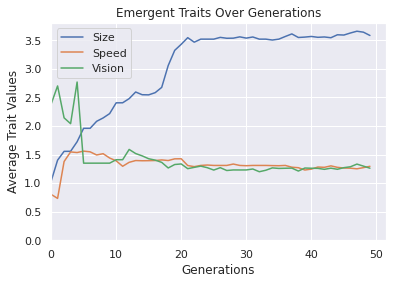

In [ ]:
df=pd.DataFrame(list(zip(sizeStat,speedStat,visionStat,numOrgs,foodEaten,ageStat,birthStat,orgEatStat,selectKillStat,totalDeathStat,averageFitness)),columns =['Size', 'Speed', 'Vision','Population','Food Eaten','Average Age','Births','Cannibalism','Nonselected Organisms','Total Death','Average Fitness'])
df.plot(y=['Size', 'Speed', 'Vision'], title = "Emergent Traits Over Generations")
plt.xlabel('Generations')
plt.ylabel('Average Trait Values')
plt.ylim(0, None)
plt.xlim(0, None)
df.describe()
df.to_csv("orgStats.csv")

(0.0, 50.0)

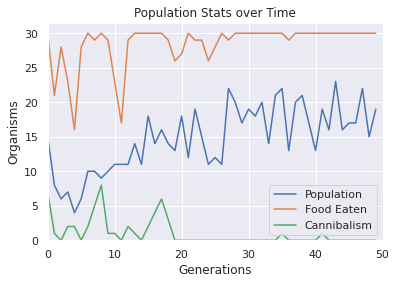

In [ ]:
df.plot(y = ['Population','Food Eaten','Cannibalism'], title = "Population Stats over Time", )
plt.xlabel('Generations')
plt.ylabel('Organisms')
plt.ylim(0, None)
plt.xlim(0, gen)

(0.0, 50.0)

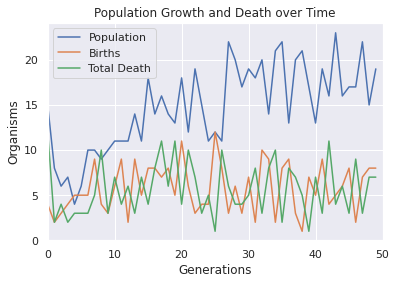

In [ ]:
df.plot(y=['Population','Births','Total Death'], title = "Population Growth and Death over Time")
plt.xlabel('Generations')
plt.ylabel('Organisms')
plt.ylim(0, None)
plt.xlim(0, gen)

(0.0, 50.0)

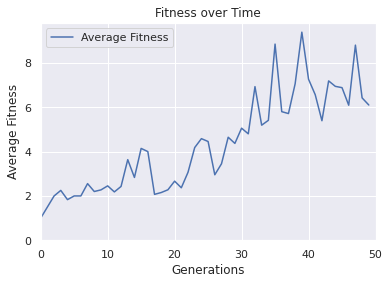

In [ ]:
df.plot(y=['Average Fitness'], title = "Fitness over Time")
plt.xlabel('Generations')
plt.ylabel('Average Fitness')
plt.ylim(0, None)
plt.xlim(0, gen)

#Plotly

In [ ]:

import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import plotly.io as pio
pio.renderers.default = 'colab'

df.iplot(kind='line',y=['Speed','Size','Vision'], xTitle= 'Generations',yTitle='Average Value', title='Trait Evolution')

In [ ]:
df.iplot(kind='line',y=['Population','Food Eaten','Cannibalism'], xTitle= 'Generations',yTitle='Organisms', title='Population Statistics')

In [ ]:
import plotly.express as px
finalOrgs = pd.DataFrame(bestOrgs, columns=['Size','Speed','Vision','Age','Fitness'])
finalOrgs.describe()
finalOrgs.to_csv("finalOrgs.csv")
fig = px.scatter_3d(finalOrgs, x='Size', y='Speed', z='Vision', title = 'Final Generation Traits')
fig.show()

#Unused ML Rose Model

In [ ]:
! pip install mlrose

In [ ]:
import mlrose

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



In [ ]:
fitness = mlrose.CustomFitness(sum)
problem = mlrose.DiscreteOpt(length = 3, fitness_fn =fitness , maximize = True, max_val = 100)

In [ ]:
mlrose.genetic_alg(problem, pop_size=10, mutation_prob=0.1, max_attempts=10, curve=True)

(array([95, 72, 87]),
 254.0,
 array([227., 248., 248., 248., 248., 248., 248., 253., 253., 253., 253.,
        254., 254., 254., 254., 254., 254., 254., 254., 254., 254., 254.]))